<a href="https://colab.research.google.com/github/Mahsalo/PeakDetection_TimeSeriesAnalysis/blob/main/ECG_peak_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import random
import pandas as pd
from scipy.stats.stats import pearsonr

In [ ]:
### Mounting the Google Drive since I have put the files on my Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


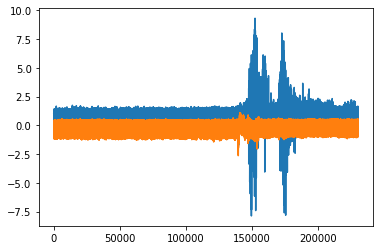

In [ ]:
### Take a look at the two variables (two views of the same event) of a single record
df1 = pd.read_csv("/content/gdrive/My Drive/ECG/s1-00_ecg.csv")
plt.plot(df1.iloc[:,0])
plt.plot(df1.iloc[:,1])

Text(0, 0.5, 'Time index of peaks')

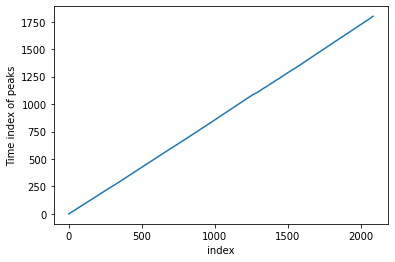

In [ ]:
### Take a look at the target values sampled at 128 HZ or 0.0078 sec
tar1 = pd.read_csv("/content/gdrive/My Drive/ECG/s1-00_ann.csv")
plt.plot(tar1)
tar1.head(5)
plt.xlabel('index')
plt.ylabel('Time index of peaks')


Since each sample is taken at (1/128)=0.0078 sec so for having the total of 230400 samples,  it must have taken 230400*0.0078 seconds which is around half an hour!

In [ ]:
#### Take a look at the shape of the data: 230400 samples each taken at 1/128 sec so the samples are taken during around half an hour
df3 = pd.read_csv("/content/gdrive/My Drive/ECG/s1-04_ecg.csv")
print('Shape of the first sample',df1.shape)
print('Shape of the second sample',df3.shape)

Shape of the first sample (230400, 2)
Shape of the second sample (230400, 2)


**Checking the correlation between two leads of ECG time series:**

I have used Pearson correlation metric to check the correlation between the two leads (time series) of each ECG record. After analyzing the statistics of the correlation vector, we see that around/nearly 25%+12.5% of the correlations are negative and the maximum correlation is around 0.75, so I think we can use a ridge regulrizer in the loss function of the regression to treat the correlation in this dataset.


In [ ]:
### Get the data and check the correlation between different variables of a dataframe
dir_name = '/content/gdrive/My Drive/ECG'
pattern1 = 'ecg'
pattern2 = 'ann'
correlation=[]
l = []
cnt = 1

n=230400 ###number of time stamps in each record
m=42 ###number of records
dummy = np.zeros((n,m))
dummy_df = pd.DataFrame(dummy)
cnt2=1
for filename in os.listdir(dir_name):
    if pattern1 in filename: ### just read the ecg files
        df = pd.read_csv(os.path.join(dir_name, filename))
        X = df.iloc[:,0]
        Y = df.iloc[:,1]
        correlation.append(pearsonr(X,Y)) ##returns correlation and pvalue
        dummy_df.iloc[:,cnt2]=X
        cnt2+=1
    elif pattern2 in filename:
        df_target= pd.read_csv(os.path.join(dir_name,filename))
        cnt+=1
    else:  
        continue
Data = dummy_df        

In [ ]:
print('Total nummber of lables',cnt)

Total nummber of lables 42


In [ ]:
cor_df = pd.DataFrame(correlation)
cor_df.describe()


,0,1
count,41.000000,41.000000
mean,0.126958,0.004560
std,0.414951,0.029198
min,-0.724696,0.000000
25%,-0.206349,0.000000
50%,0.165533,0.000000
75%,0.430121,0.000000
max,0.749945,0.186957


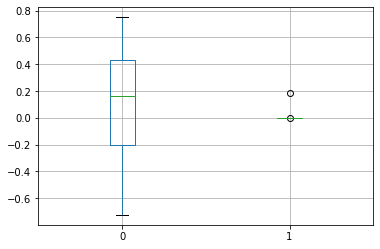

In [ ]:
cor_df.boxplot()

In [ ]:
##### Applying moving average with window size of 4 to smoothen the time series considering only the first ecg lead
def SMA(D): ### X is a one dimensional data frame and SMA returns a moving average over a window of size 4
  x=[]
  print(D)
  for i in range(0,D.shape[0]-3):
      x.append(np.round(((D.iloc[i]+ D.iloc[i+1] +D.iloc[i+2]+D.iloc[i+3])/4),1))
  return x
dir_name1 = '/content/gdrive/My Drive/ECG/s1-00_ecg.csv'
df1 = pd.read_csv(dir_name1)
res = SMA(df1.iloc[:,0])


0         1.010483
1         1.010483
2         1.010483
3         1.018389
4         1.008420
            ...   
230395    0.646452
230396    0.643358
230397    0.683118
230398    0.714858
230399    0.743389
Name: ecg1, Length: 230400, dtype: float64


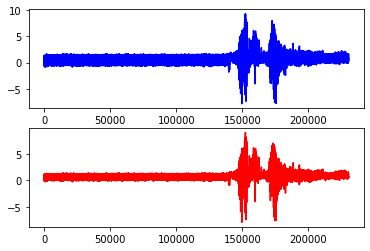

In [ ]:
### See the effect of using SMA
res_df= pd.DataFrame(res)
res_df.describe()

fig, axs = plt.subplots(2)
axs[0].plot(df1.iloc[:,0],'b')
axs[1].plot(res_df,'r')

**First Thought: Converting this regression problem into multi-class classification problem**

Since the length of the time series are the same in all samples, I would like to consider the target variable as a vector of the same length (same as the time indices of the input time series and whenever we have a peak the vector shows 1 otherwise it must show 0, So it may look like a multi-one hot vector) which is really sparse. Then we would be able to detect the peaks through time and it's similar to nlp applications in which we could have one class per word.

I think this method would result in too many output classes.

**Second Method: Using Point Anomaly Detection Using Isolation Forest**



**Modifying the target values**
The sparse modified target vector would have n=230400 components, so the original target vectors are converted into the modified by dividing their value by the smapling period which is 1/128=0.0078 (could be rounded down for integer index).


In [ ]:
### Modifying the target values
pattern2 = 'ann'
n = 230400 ### cnt is the number of labels availbale
dummyarray = np.zeros((n,cnt))
df_target = pd.DataFrame(dummyarray)
ix =1
for filename in os.listdir(dir_name):
    if pattern2 in filename:
       
        x = pd.read_csv(os.path.join(dir_name,filename))
        
        for j in range(len(x)):
          
          ind=np.floor(x.iloc[j]*128)
          dummyarray[int(ind),ix]=1

        ix+=1
DF_target = pd.DataFrame(dummyarray)      

**Data Split**

In [ ]:
#### Target shape is (230400,42)
#### Input data shape is (230400,42)
#### Splitting the data into training set and test set (70%,30%)

training_ind = np.random.choice(list(range(m)), size=(int(np.floor(0.7*m))),replace=False)
test_ind=list(set(list(range(m)))-set(training_ind))

x_train = Data.iloc[:,training_ind]
x_test = Data.iloc[:,test_ind]

y_train = DF_target.iloc[:,training_ind]
y_test = DF_target.iloc[:,test_ind]

y_train.head(10)

,39,6,28,23,38,2,17,25,0,26,7,10,20,19,35,32,9,16,29,8,36,13,4,14,27,40,18,5,12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Assigning random time stamps to the time series data**





In [ ]:

def random_dates(start, end, n, unit='D', seed=None):
    if not seed:  # from piR's answer
        np.random.seed(0)

    ndays = (end - start).days + 1
    return pd.to_timedelta(np.random.rand(n) * ndays, unit=unit) + start
np.random.seed(0)
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2018-01-01')
d=random_dates(start, end, n)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
data1 = Data.transpose()
newData = pd.DataFrame(data1.iloc[1,:].transpose().values.reshape(n,1))
newData['Time'] = d
newData.set_index('Time',inplace=True, drop=True)

newData.head(10)

,0
Time,
2014-05-24 04:21:53.739071999,-0.394376
2015-09-22 11:57:51.947164800,-0.394376
2014-10-28 21:03:22.889404800,-0.394376
2014-05-12 16:38:42.192960000,-0.397814
2013-05-23 08:13:53.339635200,-0.389014
2015-03-03 22:45:49.751481600,-0.382070
2013-07-03 01:37:04.960214400,-0.479351
2017-02-19 15:39:34.383110400,-0.523282
2017-09-17 18:52:11.908848000,-0.580826


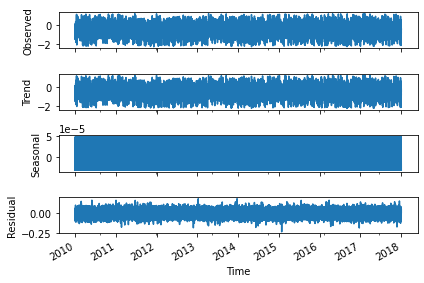

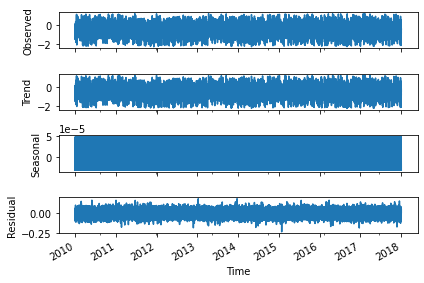

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

decomposition = seasonal_decompose(newData,model='additive',freq=3)
decomposition.plot()

**Training an Isolation Forest Model**

The contaminartion ratio shows the ratio of the outliers in the time series, we can use the information in the annotations file to see what is the ratio of outliers and then we can find the number of TP,TN,FP and FN after the prediction tof ind the accuracy and other evaluation metrics.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

outliers_fraction = float(.01)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(newData.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.01,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [ ]:
newData['anomaly'] = model.predict(data)
a = newData.loc[newData['anomaly'] == -1] #anomalies are -1
print(a)

                                      0  anomaly
Time                                            
2016-02-08 14:59:16.189411200  0.320624       -1
2014-04-30 19:59:30.172012800  0.381536       -1
2016-01-26 09:09:50.209200000  0.313061       -1
2011-02-02 16:38:12.734275200 -1.215045       -1
2017-12-13 20:43:26.566147200  0.344824       -1
...                                 ...      ...
2017-12-30 04:54:00.317894400  0.309555       -1
2012-03-13 23:17:42.011836800  0.374936       -1
2015-06-20 14:31:02.690572800  0.347093       -1
2012-02-21 06:54:06.389971200  0.300136       -1
2016-06-24 08:50:51.073065599  0.332036       -1

[2304 rows x 2 columns]


In [ ]:
targets = DF_target.iloc[:,1]
newData['target']=targets.values

In [ ]:
target_negative_ones = newData.loc[newData['anomaly']==-1]
target_negative_ones.head(10)
target_ones = newData.loc[newData['target']==1]
target_ones.head(10)


,0,anomaly,target
Time,,,
2015-03-03 22:45:49.751481600,-0.382070,1,1.0
2013-01-25 19:11:21.943219200,-0.561851,1,1.0
2014-12-11 08:21:55.407139199,-0.658926,1,1.0
2014-12-05 06:44:04.393132799,-0.674670,1,1.0
2013-05-26 08:32:06.013910400,-0.509807,1,1.0
2011-01-23 06:16:21.192787200,-0.401526,1,1.0
2012-03-22 09:55:17.213088000,-0.533389,1,1.0
2011-12-31 01:18:52.992691200,-0.477289,1,1.0
2017-05-19 07:57:47.757254400,-0.671679,1,1.0


In [ ]:
DF = newData.iloc[:,0:3]
DF.reset_index(drop=True, inplace=True)

DF.head(10)


,0,anomaly,target
0,-0.394376,1,0.0
1,-0.394376,1,0.0
2,-0.394376,1,0.0
3,-0.397814,1,0.0
4,-0.389014,1,0.0
5,-0.382070,1,1.0
6,-0.479351,1,0.0
7,-0.523282,1,0.0
8,-0.580826,1,0.0
9,-0.561851,1,1.0


Int64Index([  3866,   3867,   3868,  34975,  48144,  48145,  48146,  48302,
             59526,  59527,
            ...
            229582, 229583, 229585, 229587, 229588, 229589, 229590, 229593,
            229594, 229596],
           dtype='int64', length=2304)
[     0      1      2 ... 230397 230398 230399]


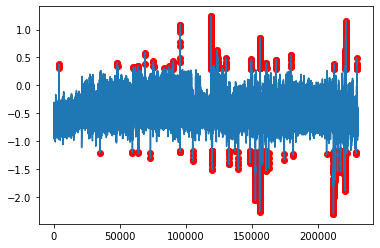

In [ ]:
xlim =np.arange(n)
plt.plot(DF.iloc[:,0])
ind=DF.loc[DF['anomaly']==-1]
print(ind.index)
plt.scatter(ind.index,DF.iloc[ind.index,0],color='r')
print(xlim)